# Session 2 - Notebook 2: Risk Analysis in Financial Modelling

In this notebook, we explore how investment risk can be measured and understood using multiple frameworks, each capturing different aspects of real-world uncertainty.

We begin with Modern Portfolio Theory (MPT), which defines risk as volatility and forms the foundation of the efficient frontier. While powerful and widely used, MPT assumes stable correlations and normally distributed returns, which often underestimate extreme market events.

Next, we introduce scenario-based risk, where historical outcomes are converted into probabilities of gains and losses. This allows risk to be interpreted intuitively as the chance of losing money, rather than abstract price fluctuations.

Finally, we examine Value at Risk (VaR) and Conditional Value at Risk (CVaR), which focus on extreme downside outcomes and quantify potential losses during market stress.

By comparing these approaches side-by-side, we highlight their strengths, limitations, and how modern risk modelling moves beyond volatility to better capture real financial risk.


## Types of Financial Risk

### 1. Systematic Risk (Market Risk)

Risk that affects the entire market or economy and cannot be diversified away.

Examples: recessions, interest rate hikes, financial crises, pandemics,inflation shocks

**Important: Even a perfectly diversified portfolio is still exposed to systematic risk.**

### 2. Unsystematic Risk (Specific Risk)

Risk unique to a company, sector, or asset and can be reduced through diversification.

Examples: poor earnings report, management scandal, product failure, negative sentiment news



---

## Downloading Historical Close Price Data

Example of selected investments to analyse:   

1. Market benchmark  
   - ^GSPC (S&P 500)  

2. Growth / Tech
   - AAPL (Apple)  
   - MSFT (Microsoft)  
   - AMZN (Amazon)  

3. Defensive equity (stable consumer demand)
   - KO (Coca-Cola)  

4. Cyclical / macro-sensitive equity (i.e., moves with oil prices, inflation cycles, global demand)

   - XOM (Exxon Mobil)  

5. Diversifiers
   - TLT (US Treasury bonds)  
   - GLD (Gold)  


This mirrors how real investors think when constructing diversified portfolios.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Market benchmark (S&P 500)
market = "^GSPC"

# Common real-world investments
tickers = [
    "^GSPC",   # S&P 500 (market)
    "AAPL",    # Apple
    "MSFT",    # Microsoft
    "AMZN",    # Amazon
    "KO",      # Coca-Cola
    "XOM",     # Exxon Mobil
    "TLT",     # US Treasury Bonds ETF
    "GLD"      # Gold ETF
]

# Start and end date of data
start_date = "2018-01-01"
end_date = None

# Download price data: Close Price
# auto_adjust automatically converts price into adjusted price
prices = yf.download(tickers, start=start_date, end = end_date, auto_adjust=True, progress=False)["Close"]
prices = prices.dropna()

# Daily returns
returns = prices.pct_change().dropna()


In [ ]:
# pip install quantstats

In [ ]:
import quantstats as qs

market_returns = returns[market]

def beta(asset, market):
    return np.cov(asset, market)[0,1] / np.var(market)

summary = pd.DataFrame(index=returns.columns)

# Performance metrics (quantstats)
summary["Annual Return"] = qs.stats.cagr(returns)
summary["Annual Volatility"] = qs.stats.volatility(returns)
summary["Sharpe"] = qs.stats.sharpe(returns)
summary["Max Drawdown"] = qs.stats.max_drawdown(returns)

# Market relationship metrics (numpy/pandas)
summary["Beta vs Market"] = [beta(returns[t], market_returns) for t in returns.columns]
summary["Correlation vs Market"] = [returns[t].corr(market_returns) for t in returns.columns]

# Alpha (risk-adjusted excess return, rf≈0)
market_annual_return = qs.stats.cagr(market_returns)

summary["Alpha"] = [
    summary.loc[t, "Annual Return"] - summary.loc[t, "Beta vs Market"] * market_annual_return
    for t in returns.columns
]

summary


,Annual Return,Annual Volatility,Sharpe,Max Drawdown,Beta vs Market,Correlation vs Market,Alpha
Ticker,,,,,,,
AAPL,0.259931,0.307057,0.906058,-0.385159,1.215523,0.772715,0.108558
AMZN,0.188713,0.343509,0.674966,-0.561453,1.179996,0.670530,0.041765
GLD,0.170537,0.157233,1.080738,-0.220022,0.074940,0.093034,0.161205
KO,0.096979,0.193016,0.576614,-0.369875,0.527759,0.533725,0.031256
MSFT,0.234093,0.285269,0.880275,-0.371485,1.175276,0.804193,0.087732
TLT,-0.017653,0.156949,-0.035098,-0.483511,-0.124930,-0.155376,-0.002095
XOM,0.114677,0.301382,0.511063,-0.610066,0.802978,0.520069,0.014680
^GSPC,0.124533,0.195294,0.699077,-0.339250,1.000493,1.000000,-0.000061


# Method 1 - Modern Portfolio Theory (MPT)

<p align="center">
<img src="https://www.investopedia.com/thmb/8E1OBoriU6LiKrWgblgBuZzIcEE=/750x0/filters:no_upscale():max_bytes(150000):strip_icc()/harrymarkowitz_round2-1b3eb541bca840ffbe11c8c849f688da.png" width="550">
</p>

*Reference:* https://www.investopedia.com/terms/h/harrymarkowitz.asp

Harry Markowitz's Modern Portfolio Theory (MPT), introduced in 1952, models how different assets can be combined to form portfolios that maximise expected return for a given level of risk, where risk is measured by return volatility.

Rather than analysing investments individually, MPT focuses on how assets move together through their correlations, showing that diversification can reduce overall portfolio risk without necessarily reducing return.

The result is the efficient frontier: a set of optimal portfolios that offer the best possible return for each level of risk, forming the foundation of modern portfolio construction.

<p align="center">
<img src="https://media.fe.training/2021/08/epmaevsq-MPT-Image-1-NEW-1920x1080.png" width="550">
</p>

*Reference:* https://www.fe.training/free-resources/financial-markets/modern-portfolio-theory/

**Step 1: Choose investable assets (exclude market benchmark)**

In [ ]:
assets = [t for t in tickers if t != market]
R = returns[assets]  # daily returns for investable assets

**Step 2: Compute MPT inputs: expected return vector and covariance matrix (annualised)**

In [ ]:
mu = R.mean() * 252        # expected annual return
cov = R.cov() * 252        # annualised covariance matrix

**Step 3: Generate random long-only portfolios**

Modern Portfolio Theory analyses portfolios as combinations of assets, not individual securities.

Each portfolio is defined by a set of weights that allocate total capital across the available assets.

We generate thousands of random long-only portfolios where:
- all weights are positive (no short selling)
- weights sum to 1 (100% of capital invested)

In [ ]:
n_portfolios = 8000
n_assets = len(assets)

weights = np.random.dirichlet(np.ones(n_assets), size=n_portfolios)  # long-only, sum=1


In [ ]:
# Show 5 random portfolios with asset breakdowns
sample_idx = np.random.choice(len(weights), size=5, replace=False)

(pd.DataFrame(
    weights[sample_idx],
    columns=assets
) * 100).round(1)


,AAPL,MSFT,AMZN,KO,XOM,TLT,GLD
0,22.4,51.5,13.3,0.8,4.1,0.4,7.5
1,45.7,1.7,19.2,2.8,4.2,11.9,14.4
2,3.9,4.5,7.6,12.7,37.8,7.1,26.4
3,4.5,0.9,45.0,10.1,10.7,25.2,3.7
4,14.5,5.8,40.2,2.4,8.7,20.7,7.7


**Step 4: Compute portfolio return, volatility, and Sharpe (rf=0)**


In [ ]:
def port_return(w, mu):
    return float(np.dot(w, mu))

def port_vol(w, cov):
    return float(np.sqrt(np.dot(w.T, np.dot(cov, w))))

port_returns = np.array([port_return(w, mu) for w in weights])
port_vols = np.array([port_vol(w, cov) for w in weights])
port_sharpes = port_returns / port_vols


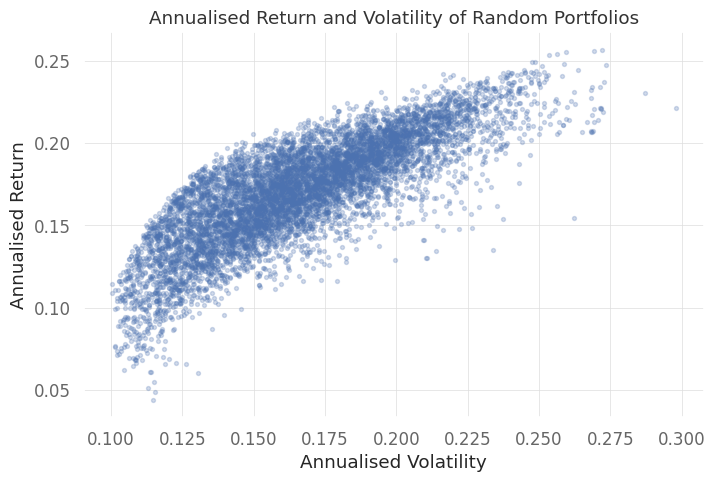

In [ ]:
# Plot the risk-return
plt.figure(figsize=(8,5))
plt.scatter(port_vols, port_returns, s=8, alpha=0.25)
plt.xlabel("Annualised Volatility")
plt.ylabel("Annualised Return")
plt.title("Annualised Return and Volatility of Random Portfolios")
plt.show()


**Step 5: Find key portfolios: Minimum Volatility & Maximum Sharpe**

After generating thousands of feasible portfolios, we now select two economically important solutions:
- Minimum volatility portfolio - the allocation with the lowest overall risk
- Maximum Sharpe portfolio - the allocation that delivers the highest return per unit of risk (assuming risk-free rate ≈ 0)

In [ ]:
idx_min_vol = np.argmin(port_vols)
idx_max_sharpe = np.argmax(port_sharpes)

w_min_vol = weights[idx_min_vol]
w_max_sharpe = weights[idx_max_sharpe]

min_vol_point = (port_vols[idx_min_vol], port_returns[idx_min_vol])
max_sharpe_point = (port_vols[idx_max_sharpe], port_returns[idx_max_sharpe])

pd.DataFrame({
    "Asset": assets,
    "Weight (Min Vol)": w_min_vol,
    "Weight (Max Sharpe)": w_max_sharpe
})


,Asset,Weight (Min Vol),Weight (Max Sharpe)
0,AAPL,0.053512,0.152328
1,MSFT,0.029652,0.107414
2,AMZN,0.024453,0.021724
3,KO,0.179627,0.023416
4,XOM,0.073384,0.110412
5,TLT,0.303543,0.000982
6,GLD,0.335829,0.583725


**Step 6: Approximate the efficient frontier**

After generating thousands of feasible portfolios, we now extract the efficient frontier — the set of portfolios that offer the highest return for each level of risk (or equivalently, the lowest risk for each level of return).

Instead of solving a constrained optimisation problem directly, we approximate the frontier using the sampled portfolios:

1. We define a range of target portfolio returns from the lowest to highest observed return
2. For each target return, we select all portfolios that achieve at least that return
3. Among those portfolios, we keep the one with the minimum volatility
4. Repeating this across targets traces out the efficient boundary

The resulting curve represents the best achievable risk–return trade-offs under long-only diversification.

In [ ]:
target_returns = np.linspace(port_returns.min(), port_returns.max(), 30)

frontier_vols = []
frontier_rets = []

for tr in target_returns:
    mask = port_returns >= tr
    if mask.sum() == 0:
        continue
    frontier_vols.append(port_vols[mask].min())
    frontier_rets.append(tr)


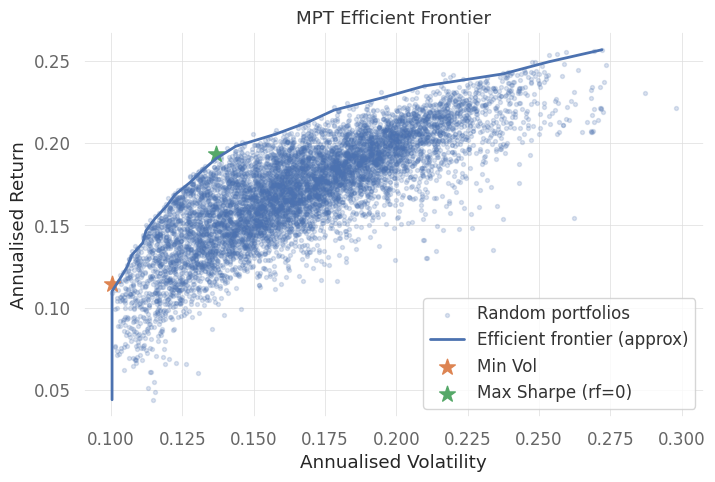

In [ ]:
plt.figure(figsize=(8,5))

plt.scatter(port_vols, port_returns, s=8, alpha=0.20, label="Random portfolios")
plt.plot(frontier_vols, frontier_rets, linewidth=2, label="Efficient frontier (approx)")

plt.scatter([min_vol_point[0]], [min_vol_point[1]], s=140, marker="*", label="Min Vol")
plt.scatter([max_sharpe_point[0]], [max_sharpe_point[1]], s=140, marker="*", label="Max Sharpe (rf=0)")

plt.xlabel("Annualised Volatility")
plt.ylabel("Annualised Return")
plt.title("MPT Efficient Frontier")
plt.legend()
plt.show()


Each point on the frontier is an optimal portfolio:
- lowest possible risk for a given return
- highest possible return for a given risk

This means you can:

1. Choose a risk level → get the best portfolio
(conservative investor → low volatility point)
2. Choose a return target → get the least risky mix
(growth investor → higher frontier point)
3. Compare real portfolios vs optimal ones
Anything below the frontier is inefficient.

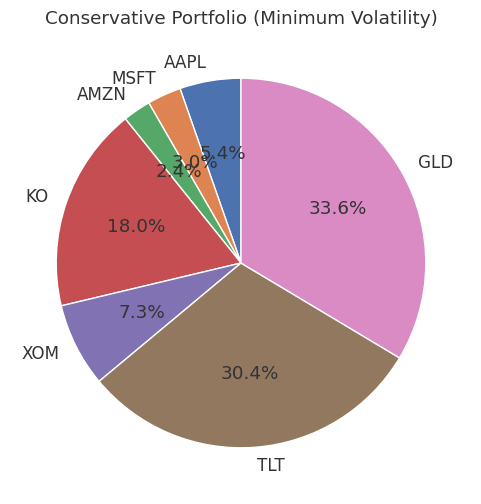

In [ ]:
# Conservative investor — Minimum volatility portfolio
plt.figure(figsize=(6,6))
plt.pie(
    w_min_vol,
    labels=assets,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Conservative Portfolio (Minimum Volatility)")
plt.show()


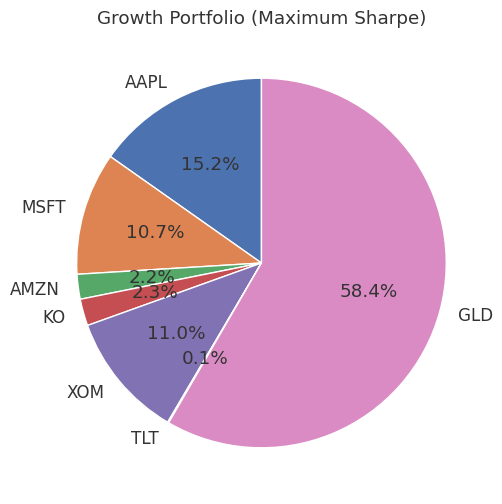

In [ ]:
# Growth investor — Maximum Sharpe portfolio
plt.figure(figsize=(6,6))
plt.pie(
    w_max_sharpe,
    labels=assets,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Growth Portfolio (Maximum Sharpe)")
plt.show()



### Limitations and Drawbacks of Modern Portfolio Theory (MPT)

While MPT provides a powerful framework for diversification and optimal portfolio construction, it relies on several simplifying assumptions that often break down in real financial markets.

1. MPT treats all price fluctuations as risk — both gains and losses.
2. Returns are assumed to be stable and normally distributed
3. Correlations are assumed constant - Diversification depends heavily on low correlation.
4. Small changes in expected returns can produce very different “optimal” portfolios.

Let's examine the correlation between the assets.

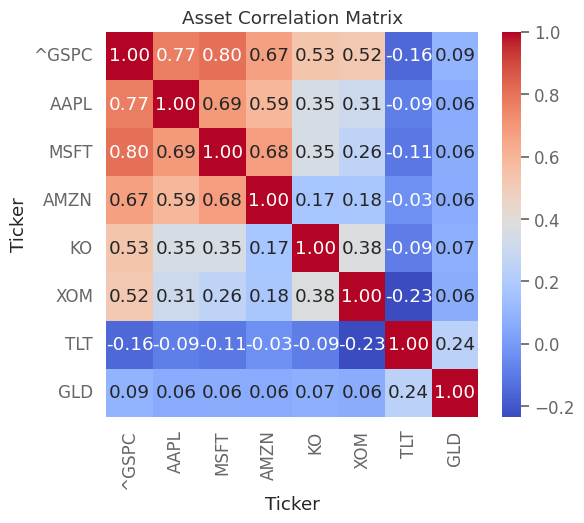

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(returns[tickers].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Asset Correlation Matrix")
plt.show()


#### Downside deviation/volatility

Looks at only negative returns (or returns below a target), how large those losses typically are and how it is averaged over time

<p align="center">
<img src="https://cdn.tradeforgood.com.au/app/uploads/2024/08/sr-5.png?strip=all&lossy=1&ssl=1" width="500">
</p>

*Reference:* https://www.rcmalternatives.com/2013/09/sortino-ratio-are-you-calculating-it-wrong/


In [ ]:
threshold = 0.0  # target daily return (0 = focus on losses)

downside_dev = np.sqrt(
    252 * ((np.minimum(0, R - threshold)) ** 2).mean()
)

downside_dev.sort_values().to_frame(name="Downside Deviation")

,Downside Deviation
Ticker,
TLT,0.110337
GLD,0.110363
KO,0.138017
MSFT,0.195271
AAPL,0.208276
XOM,0.208689
AMZN,0.234932


Observations vs MPT Portfolio (Minimum Volatility):

- The MPT conservative portfolio loads heavily into TLT and GLD
- These same assets have the lowest downside deviation
- Tech stocks comes with larger downside swings

**Important: MPT can produce sensible portfolios but it has no built-in protection against losses or crashes. Downside risk measures what volatility ignores.**


### Try Yourself: Post-Modern Portfolio Theory Efficient Frontier

Using the same asset returns and portfolio framework as in MPT, construct a Post-Modern Portfolio Theory (PMPT) efficient frontier by:

- replacing portfolio volatility with downside deviation as the risk measure
- optimising portfolios using the Sortino ratio instead of the Sharpe ratio

$
\text{Sortino} = \frac{R_{\text{portfolio}} - R_f}{\sigma_{\text{down}}}
$

- plotting the new risk–return frontier based on downside risk

Compare the PMPT frontier with the original MPT frontier and briefly comment on how portfolio allocations and risk exposure change.

---

# Method 2 - Scenario-Based Risk-Return Analysis

In the scenario-based approach, we model risk and return not by statistical volatility but by actual potential outcomes and their likelihoods. Instead of treating all return variation as risk, this method asks:

```
"If I invest £1 today, what are the possible results after a given horizon, and how likely is each?"
```

By constructing a set of discrete return multiples (e.g., big loss, small loss, break-even, gain, big gain) and assigning probabilities to each based on historical data, we can compute:

* an expected return multiple (the average payoff per one pound invested)
* the probability of loss (risk of ending with less than one pound).

This framework directly captures how often and how severely losses occur — information that volatility alone does not provide and naturally categorises investments into desirable and undesirable risk–return combinations.

<p align="center">
<img src="https://www.extension.iastate.edu/agdm/wholefarm/html/images/c5-214fig1.gif" width="300">
</p>

*Reference:* https://www.extension.iastate.edu/agdm/wholefarm/html/c5-214.html


### Preliminary: **Simple Risk-Return Classification**

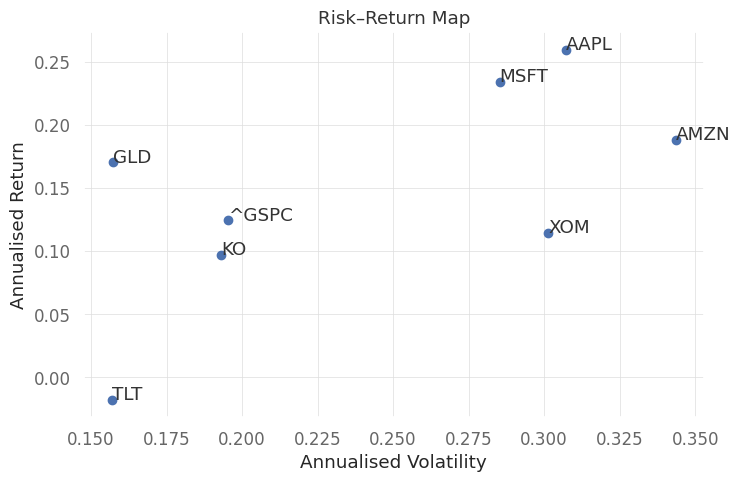

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(summary["Annual Volatility"], summary["Annual Return"])

for t in summary.index:
    plt.annotate(t, (summary.loc[t,"Annual Volatility"], summary.loc[t,"Annual Return"]))

plt.xlabel("Annualised Volatility")
plt.ylabel("Annualised Return")
plt.title("Risk–Return Map")
plt.show()


To assign assets into intuitive risk–return regions, the code uses the average annual volatility as the risk threshold and the average annual return as the return threshold. A *vertical line* is drawn at the *mean volatility* to separate lower-risk from higher-risk assets, while a *horizontal line* at the *mean return* separates lower-return from higher-return assets.

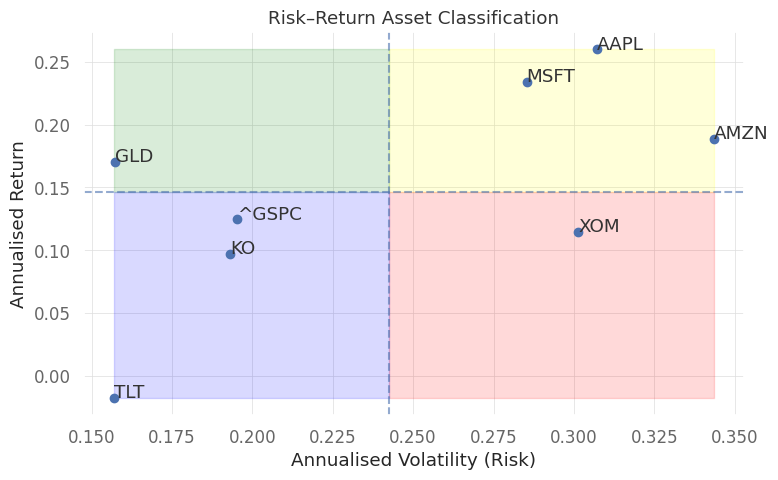

In [ ]:
x = summary["Annual Volatility"]
y = summary["Annual Return"]

x_mid = x.mean()
y_mid = y.mean()

plt.figure(figsize=(8,5))

# Define plot bounds
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# Background regions (NOW aligned to x_mid and y_mid in data units)
plt.fill_betweenx([y_mid, y_max], x_min, x_mid, alpha=0.15, color="green")   # low risk, high return
plt.fill_betweenx([y_mid, y_max], x_mid, x_max, alpha=0.15, color="yellow")  # high risk, high return
plt.fill_betweenx([y_min, y_mid], x_min, x_mid, alpha=0.15, color="blue")    # low risk, low return
plt.fill_betweenx([y_min, y_mid], x_mid, x_max, alpha=0.15, color="red")     # high risk, low return

# Scatter points
plt.scatter(x, y, zorder=3)

for t in summary.index:
    plt.annotate(t, (x.loc[t], y.loc[t]))

# Mid reference lines
plt.axvline(x_mid, linestyle="--", alpha=0.6)
plt.axhline(y_mid, linestyle="--", alpha=0.6)

plt.xlabel("Annualised Volatility (Risk)")
plt.ylabel("Annualised Return")
plt.title("Risk–Return Asset Classification")
plt.tight_layout()
plt.show()


### **Return - Risk of Loss Classification**

**Step 1: Compute Multiple**

E.g., "If I invested in Apple on any past day and held for one year, what actually happened?"

$
\text{Multiple} = \dfrac{\text{Price in 1 year}}{\text{Price today}}
$

So each value answers:
- 1.25 → investment grew 25%
- 0.80 → investment lost 20%
- 1.00 → broke even

In [ ]:
asset = "AAPL"
price_series = prices[asset]

# Compute multiple for per trading year
horizon = 252
multiples = (price_series.shift(-horizon) / price_series).dropna()
multiples.tail()


,AAPL
Date,
2025-01-23,1.147121
2025-01-24,1.164548
2025-01-27,1.120681
2025-01-28,1.088929
2025-01-29,1.088960


**Step 2: Categorise the multiples**

For example,
- Loss scenario where the investment falls by more than around 5%,
- Flat scenario where the price remains roughly unchanged (within ±5%),
- Gain scenario where the investment increases meaningfully.

These ranges simplify thousands of historical outcomes into interpretable categories.

In [ ]:
bins = [-np.inf, 0.95, 1.05, np.inf]
labels = ["Loss", "Flat", "Gain"]

bucket = pd.cut(multiples, bins=bins, labels=labels)

bucket.tail()

,AAPL
Date,
2025-01-23,Gain
2025-01-24,Gain
2025-01-27,Gain
2025-01-28,Gain
2025-01-29,Gain


**Step 3: Creating a discrete outcome scenario table**

The *probability of each scenario* by counting how often each label appears relative to the total number of observations. This gives an empirical estimate of how frequently losses, flat periods, and gains occurred in the past.

To represent the typical *magnitude of each outcome*, we calculate the median multiple within each scenario. This provides a realistic payoff level for a loss year, flat year, and gain year without being distorted by extreme values.

Finally, these scenario magnitudes and probabilities are combined into a single table, forming a simple scenario-based risk model that captures both how often losses occur and how large they tend to be.

In [ ]:
probabilities = bucket.value_counts(normalize=True).sort_index()
scenario_multiples = multiples.groupby(bucket).median()

outcomes = pd.DataFrame({
    "Scenario": probabilities.index,
    "Median Multiple": scenario_multiples.values,
    "Probability": probabilities.values
})

outcomes

/tmp/ipython-input-1424079626.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scenario_multiples = multiples.groupby(bucket).median()


,Scenario,Median Multiple,Probability
0,Loss,0.899494,0.073637
1,Flat,1.009847,0.141653
2,Gain,1.287754,0.784711


**Step 4: Compute expected return and risk of loss**

1. Expected return = probability-weighted average of all scenario outcomes, showing how much the investment is expected to grow after one year.

2. The probability of loss measures the chance that the return multiple falls below 1, meaning the investment ends the year with a negative return.

In [ ]:
# Expected return
expected_multiple = (outcomes["Median Multiple"] * outcomes["Probability"]).sum()
print(f"Expected return multiple (1-year horizon): {expected_multiple:.3f}")

# Probability of loss
risk_of_loss = outcomes.loc[outcomes["Median Multiple"] < 1, "Probability"].sum()
print(f"Probability of loss: {risk_of_loss:.2%}")

Expected return multiple (1-year horizon): 1.220
Probability of loss: 7.36%


**Step 5: Plot risk of loss-return classification**

The following thresholds can be changed according to investor preference.

1. Horizontal line = 1 (represents breakeven return)

- above 1 → expected profit
- below 1 → expected loss

2. Vertical line = 0.5 (represents investor risk threshold)

This means 50% chance of losing money.

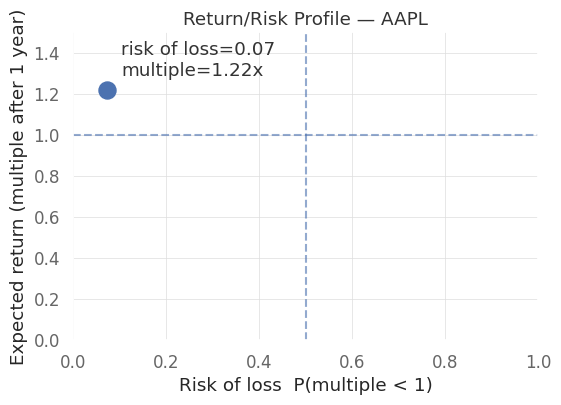

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter([risk_of_loss], [expected_multiple], s=150)

plt.axvline(0.5, linestyle="--", alpha=0.6)
plt.axhline(1.0, linestyle="--", alpha=0.6)

plt.xlim(0,1)
plt.ylim(0, max(1.5, expected_multiple + 0.2))

plt.xlabel("Risk of loss  P(multiple < 1)")
plt.ylabel("Expected return (multiple after 1 year)")
plt.title(f"Return/Risk Profile — {asset}")

plt.annotate(f"risk of loss={risk_of_loss:.2f}\nmultiple={expected_multiple:.2f}x",
             (risk_of_loss, expected_multiple),
             textcoords="offset points", xytext=(10,10))

plt.show()


### Try Yourself: Return-Risk of loss classification

a) Use another asset,

b) Change the scenario type (e.g., big loss, small loss, break-even, gain, big gain)

---

## Method 3 — VaR and CVaR (Tail Risk)

VaR and CVaR focus specifically on extreme downside outcomes.


<p align="center">
<img src="https://www.researchgate.net/profile/Andres-Ramos-12/publication/226393412/figure/fig4/AS:626102410162180@1526285855948/aR-and-CVaR-illustration_W640.jpg" width="300">
</p>

*Reference:* https://www.researchgate.net/publication/226393412_Stochasticity_in_Electric_Energy_Systems_Planning/figures?lo=1

1. VaR (at 5%) tells you the loss threshold that is only exceeded in the worst 5% of days (a “bad-day cutoff”)

2. CVaR (at 5%) tells you the average loss across those worst 5% days.

This is useful because it targets tail risk directly, rather than treating all volatility equally.

In [ ]:
def var_cvar(r, alpha=0.05):
    var = r.quantile(alpha)
    cvar = r[r <= var].mean()
    return var, cvar

downside = pd.DataFrame(index=assets, columns=["VaR 5%", "CVaR 5%"])

for t in assets:
    var, cvar = var_cvar(returns[t], alpha=0.05)
    downside.loc[t, "VaR 5%"] = var
    downside.loc[t, "CVaR 5%"] = cvar

downside = downside.astype(float).sort_values("CVaR 5%")

(downside * 100).round(2)


,VaR 5%,CVaR 5%
AMZN,-3.28,-4.90
AAPL,-2.98,-4.39
XOM,-2.83,-4.30
MSFT,-2.76,-4.04
KO,-1.66,-2.87
GLD,-1.53,-2.26
TLT,-1.56,-2.14


How to interpret the values?

- AMZN has VaR ≈ -3.28% → on a bad day, losses typically exceed 3.3%
but CVaR ≈ -4.90% → when crashes happen, the average loss is almost 5%
- VaR/CVaR show exactly how painful the bad days are.


